In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import scikitplot as skplt
import plotly.express as px
matplotlib.rcParams["figure.figsize"] = (20, 10)

from pandas import ExcelWriter
from pandas import ExcelFile

In [2]:
df = pd.read_csv("Sample_Real Estate Evaluation.csv")
df.head(5)

,Points of location (ot of 20),Type,Price(B) tax exclus,Use of property,Building style,Available commercial area (D) sqft,Building area (at ground level) (E) sqft,Lot area(F),Parking\n(Driveway),Parking\n(Garage),Parking\n(Asphalt),Parking\n(Paving stone),Parking\n(Unpaved),Number of units\n(Residential ),Number of units\n(Industrial),Number of units\n(Commercial),Number of units\n(Office),Number of units (G)
0,17,Quintuplex,"$1,200,000.00","Residential, Commercial",Attached,0,0,1849,0,0,0,0,0,4,1,0,0,5.0
1,17,Quadruplex,"$999,000.00",Residential,Detached,0,878,2651,0,0,0,0,0,4,0,0,0,4.0
2,11,Triplex,"$989,000.00",Residential,Attached,0,0,"2,315",3,0,0,0,0,4,0,0,0,4.0
3,14,Triplex,"$1,649,000.00",Residential,Attached,"1,028","1,017","1,187",0,0,0,0,0,3,0,0,0,4.0
4,14,Duplex,"$1,199,000.00","Residential, Commercial",Attached,0,0,"2,193",0,0,0,0,0,1,0,1,0,3.0


Data Cleaning

In [3]:
df = df.drop(['Number of units\n(Residential )', 'Number of units\n(Industrial)', 'Number of units\n(Commercial)', 'Number of units\n(Office)'], axis='columns')

df['Parking\n(Driveway)'] = df['Parking\n(Driveway)'].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=['Parking\n(Driveway)'], inplace=True)

df['Number of Parkings'] = df['Parking\n(Asphalt)'] + df['Parking\n(Driveway)'] + df['Parking\n(Garage)'] + df['Parking\n(Paving stone)'] + df['Parking\n(Unpaved)']
df = df.drop(['Parking\n(Asphalt)', 'Parking\n(Driveway)', 'Parking\n(Garage)', 'Parking\n(Paving stone)', 'Parking\n(Unpaved)'], axis='columns')

df.isnull().sum()

Points of location (ot of 20)               0
Type                                        0
Price(B) tax exclus                         0
Use of property                             0
Building style                              0
Available commercial area (D) sqft          0
Building area (at ground level) (E) sqft    0
Lot area(F)                                 5
Number of units (G)                         3
Number of Parkings                          0
dtype: int64

In [4]:
def remove_comma(x):
    if isinstance(x, str):
        x = x.replace(',','')
        return float(x)
    return x

In [5]:
df = df.dropna()

df['Lot area(F)'] = df['Lot area(F)'].apply(remove_comma)
df['Building area (at ground level) (E) sqft'] = df['Building area (at ground level) (E) sqft'].apply(remove_comma)

df['Area sqft'] = df['Lot area(F)'] + df['Building area (at ground level) (E) sqft']

df = df.drop(['Lot area(F)', 'Building area (at ground level) (E) sqft'], axis='columns')

df = df[df['Area sqft'] != 0]

Now we want to handle the range areas for Available commercial area

First we define a function to recognize range data
Then we handle them by taking the average of them

In [6]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [7]:
# df['Available commercial area (D) sqft'] = df[df['Available commercial area (D) sqft'].apply(is_float)].apply(remove_comma)

In [8]:
df[~df['Available commercial area (D) sqft'].apply(is_float)]

,Points of location (ot of 20),Type,Price(B) tax exclus,Use of property,Building style,Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft
3,14,Triplex,"$1,649,000.00",Residential,Attached,"1,028",4.0,0.0,2204.0
5,17,Triplex,"$1,499,000.00",Residential,Semi-detached,"725 , 2,175",2.0,4.0,4623.0
51,14,Quintuplex,"$1,249,000",Residential,Attached,"1,100",5.0,0.0,2750.0
61,11,Triplex,"$949,900",Residential,Attached,"2,100",2.0,0.0,2295.0
63,11,Duplex,"$899,000",Residential,Semi-detached,"1,270",3.0,0.0,2292.0
69,11,Duplex,"$849,900",Residential,Attached,"1,250",4.0,0.0,2750.0
72,11,Duplex,"$999,000","Residential, Commercial",Attached,"384 , 1,134",2.0,4.0,2325.0
82,11,Triplex,"$830,000",Residential,Attached,"1,100",3.0,0.0,2660.0
84,11,Triplex,"$949,000",Residential,Attached,"400 , 2,500",3.0,1.0,2145.0
97,14,Duplex,"$950,000",Residential,Attached,"1,850",2.0,1.0,1200.0


In [9]:
def comm_area_avg(x):
    tokens = x.split(' , ')
    if len(tokens) == 2:
        tokens[1] = tokens[1].replace(',', '')
        return (float(tokens[0]) + float(tokens[1]))/2
    return x

In [10]:
df['Available commercial area (D) sqft'] = df['Available commercial area (D) sqft'].apply(comm_area_avg).apply(remove_comma)

In [11]:
df.head(10)

,Points of location (ot of 20),Type,Price(B) tax exclus,Use of property,Building style,Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft
0,17,Quintuplex,"$1,200,000.00","Residential, Commercial",Attached,0.0,5.0,0.0,1849.0
1,17,Quadruplex,"$999,000.00",Residential,Detached,0.0,4.0,0.0,3529.0
2,11,Triplex,"$989,000.00",Residential,Attached,0.0,4.0,3.0,2315.0
3,14,Triplex,"$1,649,000.00",Residential,Attached,1028.0,4.0,0.0,2204.0
4,14,Duplex,"$1,199,000.00","Residential, Commercial",Attached,0.0,3.0,0.0,2193.0
5,17,Triplex,"$1,499,000.00",Residential,Semi-detached,1450.0,2.0,4.0,4623.0
6,14,Triplex,"$1,795,000.00","Residential, Commercial",Semi-detached,0.0,3.0,7.0,4492.0
7,14,6 units multi-family building,"$1,790,000.00",Residential,0,0.0,3.0,1.0,6131.0
9,14,Triplex,"$1,647,000.00",Residential,Semi-detached,0.0,3.0,3.0,2315.0
12,14,Triplex,"$1,299,000.00","Residential, Commercial",Semi-detached,0.0,3.0,0.0,6075.0


Removing data with no Use of property

In [12]:
df[df['Use of property'].apply(is_float)]

,Points of location (ot of 20),Type,Price(B) tax exclus,Use of property,Building style,Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft
142,14,Triplex,"$1,495,000",0,Semi-detached,0.0,5.0,2.0,2000.0
143,14,Triplex,"$1,275,000",0,Semi-detached,0.0,3.0,2.0,2026.0


In [13]:
df = df[~df['Use of property'].apply(is_float)]
df

,Points of location (ot of 20),Type,Price(B) tax exclus,Use of property,Building style,Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft
0,17,Quintuplex,"$1,200,000.00","Residential, Commercial",Attached,0.0,5.0,0.0,1849.0
1,17,Quadruplex,"$999,000.00",Residential,Detached,0.0,4.0,0.0,3529.0
2,11,Triplex,"$989,000.00",Residential,Attached,0.0,4.0,3.0,2315.0
3,14,Triplex,"$1,649,000.00",Residential,Attached,1028.0,4.0,0.0,2204.0
4,14,Duplex,"$1,199,000.00","Residential, Commercial",Attached,0.0,3.0,0.0,2193.0
...,...,...,...,...,...,...,...,...,...
137,14,Triplex,"$1,248,000",Residential,Semi-detached,0.0,2.0,0.0,2750.0
139,14,Quadruplex,"$1,590,000",Residential,Semi-detached,0.0,4.0,4.0,2401.0
140,14,Quadruplex,"$1,135,000",Residential,Semi-detached,0.0,13.0,0.0,2133.0
141,14,Quadruplex,"$2,795,000",Residential,Semi-detached,0.0,6.0,0.0,1284.0


In [14]:
df[df['Building style'].apply(is_float)]

,Points of location (ot of 20),Type,Price(B) tax exclus,Use of property,Building style,Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft
7,14,6 units multi-family building,"$1,790,000.00",Residential,0,0.0,3.0,1.0,6131.0
14,14,6 Plex,"$1,100,000.00","Residential, Commercial",0,0.0,6.0,0.0,1900.0
15,7,6 Plex,"$1,559,000.00",Residential,0,0.0,4.0,6.0,2422.0
124,11,-,"$999,000","Residential, Commercial",0,0.0,2.0,0.0,3734.0


In [15]:
df = df[~df['Building style'].apply(is_float)]
df

,Points of location (ot of 20),Type,Price(B) tax exclus,Use of property,Building style,Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft
0,17,Quintuplex,"$1,200,000.00","Residential, Commercial",Attached,0.0,5.0,0.0,1849.0
1,17,Quadruplex,"$999,000.00",Residential,Detached,0.0,4.0,0.0,3529.0
2,11,Triplex,"$989,000.00",Residential,Attached,0.0,4.0,3.0,2315.0
3,14,Triplex,"$1,649,000.00",Residential,Attached,1028.0,4.0,0.0,2204.0
4,14,Duplex,"$1,199,000.00","Residential, Commercial",Attached,0.0,3.0,0.0,2193.0
...,...,...,...,...,...,...,...,...,...
137,14,Triplex,"$1,248,000",Residential,Semi-detached,0.0,2.0,0.0,2750.0
139,14,Quadruplex,"$1,590,000",Residential,Semi-detached,0.0,4.0,4.0,2401.0
140,14,Quadruplex,"$1,135,000",Residential,Semi-detached,0.0,13.0,0.0,2133.0
141,14,Quadruplex,"$2,795,000",Residential,Semi-detached,0.0,6.0,0.0,1284.0


In [16]:
# Cleaning Price and separating Price (lable) from other features

df = df[df['Price(B) tax exclus'] != '0']
price = df['Price(B) tax exclus']

In [17]:
def remove_dollar_sign(x):
    x = x.replace('$', '')
    x = x.replace(',', '')
    return float(x)

In [18]:
price = price.apply(remove_dollar_sign)
(price == 0).sum() # So we make sure we do not have any 0 Price

0

In [19]:
df['Price per sqft'] = df['Price(B) tax exclus'].apply(remove_dollar_sign) / df['Area sqft']

df['Price per unit'] = df['Price(B) tax exclus'].apply(remove_dollar_sign) / df['Number of units (G)']

df = df.drop('Price(B) tax exclus', axis='columns')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19284\3926662498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price per sqft'] = df['Price(B) tax exclus'].apply(remove_dollar_sign) / df['Area sqft']
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19284\3926662498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price per unit'] = df['Price(B) tax exclus'].apply(remove_dollar_sign) / df['Number of units (G)']


In [20]:
df['Type'].unique()

array(['Quintuplex', 'Quadruplex', 'Triplex', 'Duplex', 'triplex',
       '6 Plex', '16-units', '5-Plex', 'House'], dtype=object)

In [21]:
def correct_category(x):
    
    x = x.replace('triplex', 'Triplex')
    x = x.replace('Quintuplex', '5-Plex')
    x = x.replace('Residential\n, Commercial', 'Residential, Commercial')
    x = x.replace('Attached corner unit', 'Attached')
    x = x.replace('Two or more storey, Semi-detached', 'Semi-detached')
    x = x.replace('Two or more storey, Detached', 'Detached')
    x = x.replace('Bungalow, Detached', 'Detached')
    x = x.replace('Split-level, Detached', 'Detached')
    
    return x

In [22]:
df['Type'] = df['Type'].apply(correct_category)
df['Type'].unique()

array(['5-Plex', 'Quadruplex', 'Triplex', 'Duplex', '6 Plex', '16-units',
       'House'], dtype=object)

In [23]:
df['Use of property'] = df['Use of property'].apply(correct_category)
df['Use of property'].unique()

array(['Residential, Commercial', 'Residential'], dtype=object)

In [24]:
df['Building style'] = df['Building style'].apply(correct_category)
df['Building style'].unique()

array(['Attached', 'Detached', 'Semi-detached'], dtype=object)

In [25]:
df2 = pd.get_dummies(df, columns=['Type', 'Use of property', 'Building style'])

In [26]:
df2

,Points of location (ot of 20),Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft,Price per sqft,Price per unit,Type_16-units,Type_5-Plex,Type_6 Plex,Type_Duplex,Type_House,Type_Quadruplex,Type_Triplex,Use of property_Residential,"Use of property_Residential, Commercial",Building style_Attached,Building style_Detached,Building style_Semi-detached
0,17,0.0,5.0,0.0,1849.0,648.999459,240000.000000,0,1,0,0,0,0,0,0,1,1,0,0
1,17,0.0,4.0,0.0,3529.0,283.083026,249750.000000,0,0,0,0,0,1,0,1,0,0,1,0
2,11,0.0,4.0,3.0,2315.0,427.213823,247250.000000,0,0,0,0,0,0,1,1,0,1,0,0
3,14,1028.0,4.0,0.0,2204.0,748.185118,412250.000000,0,0,0,0,0,0,1,1,0,1,0,0
4,14,0.0,3.0,0.0,2193.0,546.739626,399666.666667,0,0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,14,0.0,2.0,0.0,2750.0,453.818182,624000.000000,0,0,0,0,0,0,1,1,0,0,0,1
139,14,0.0,4.0,4.0,2401.0,662.224073,397500.000000,0,0,0,0,0,1,0,1,0,0,0,1
140,14,0.0,13.0,0.0,2133.0,532.114393,87307.692308,0,0,0,0,0,1,0,1,0,0,0,1
141,14,0.0,6.0,0.0,1284.0,2176.791277,465833.333333,0,0,0,0,0,1,0,1,0,0,0,1


In [27]:
price

0      1200000.0
1       999000.0
2       989000.0
3      1649000.0
4      1199000.0
         ...    
137    1248000.0
139    1590000.0
140    1135000.0
141    2795000.0
146    1525000.0
Name: Price(B) tax exclus, Length: 124, dtype: float64

In [28]:
X = df2
y = price

In [29]:
# We split train and test smaples (80% of the data is going to train the model and 20% of data is going to test the model)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [30]:
#we test the score of a linear regression model

from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test,y_test)

0.6035612144666672

In [74]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

def find_best_model_using_gridSearchCV(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'copy_X' : [True, False],
                'fit_intercept' : [True, False],
                'n_jobs' : [1,2,3],
                'positive' : [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha' : [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
             'model': DecisionTreeRegressor(),
             'params': {
                 'criterion': ['mse', 'friedman_mse'],
                 'splitter': ['best', 'random']
             }
        },
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [75]:
find_best_model_using_gridSearchCV(X,y)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.713e+12, tolerance: 2.570e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e+12, tolerance: 1.196e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.649e+12, tolerance: 

,model,best_score,best_params
0,linear_regression,0.556900,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
1,lasso,0.564582,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,-0.077139,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [67]:
# Here we can enter new features and get the predicted price

def predict_price(type_prop, point_of_loc, available_commercial_area, num_of_units, num_of_parkings, area):
    type_idx = np.where(X.columns==type_prop)[0][0]
    x = np.zeros(len(X.columns))
    
    x[0] = point_of_loc
    x[1] = available_commercial_area
    x[2] = num_of_units
    x[3] = num_of_parkings
    x[4] = area
    if type_idx >= 0:
        x[type_idx] = 1
        
    return lr_clf.predict([x])[0]

In [90]:
predict_price('Type_5-Plex', 11, 0, 4, 6, 3500)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


941317.7222474401

Point of loc: 0.078204
availble commercial area: 0.000000
num of units: 0.133335
num of parkings: 0.000000
area: 0.155882
price/sqft: 0.211390
price/units: 0.045060
Type_16-units: 0.126866
Type_5-Plex: 0.046051
Type_6 Plex: 0.000000
Type_Duplex: 0.000000
Type_House: 0.000000
Type_Quadruplex: 0.155284
Type_Triplex: 0.078180
Use of property_Residential: 0.032592
Use of property_Residential, Commercial: 0.003321
Building style_Attached: 0.062215
Building style_Detached: 0.000000
Building style_Semi-detached: 0.053727


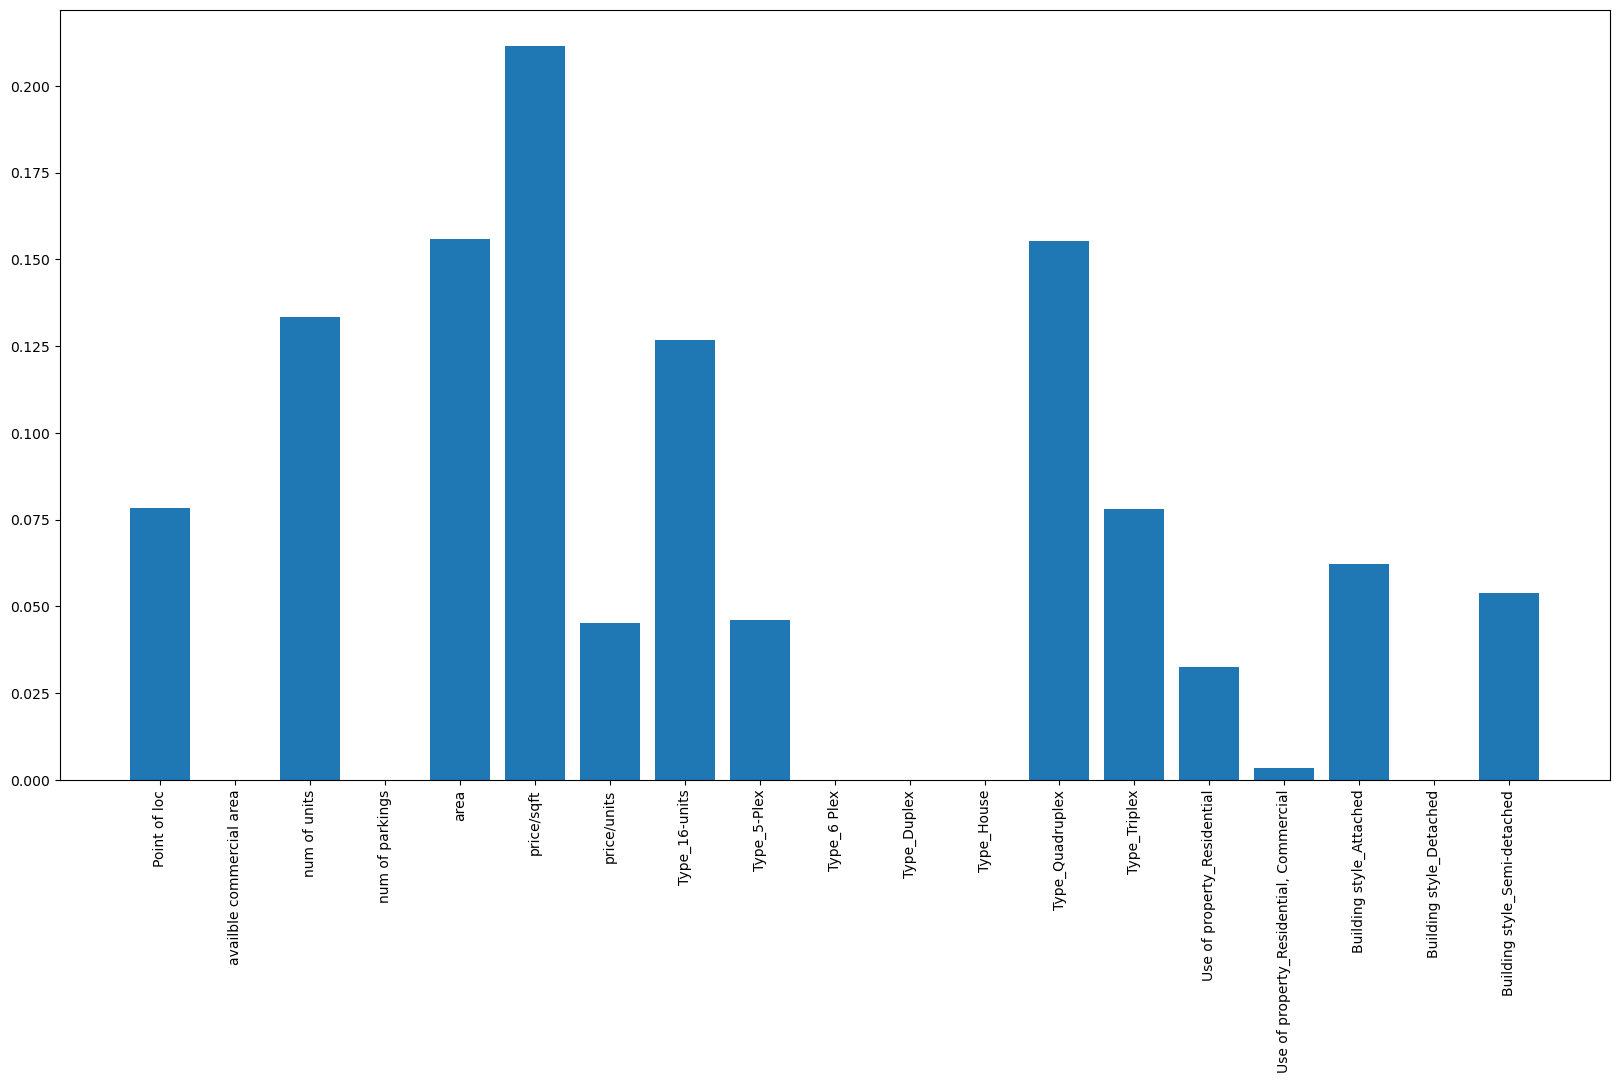

In [39]:
# example of mutual information feature selection for numerical input data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot

Features = ['Point of loc', 'availble commercial area', 'num of units', 'num of parkings', 'area', 'price/sqft', 'price/units', 'Type_16-units', 'Type_5-Plex', 'Type_6 Plex', 'Type_Duplex', 'Type_House', 'Type_Quadruplex', 'Type_Triplex', 'Use of property_Residential', 'Use of property_Residential, Commercial', 'Building style_Attached', 'Building style_Detached', 'Building style_Semi-detached']

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# load the dataset
X, y = make_regression(n_samples=100, n_features=19, n_informative=10, noise=0.1, random_state=1)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print(Features[i] + ': %f' % (fs.scores_[i]))
# plot the scores
pyplot.bar(Features, fs.scores_)
pyplot.xticks(rotation=90)
pyplot.show()

<Axes: >

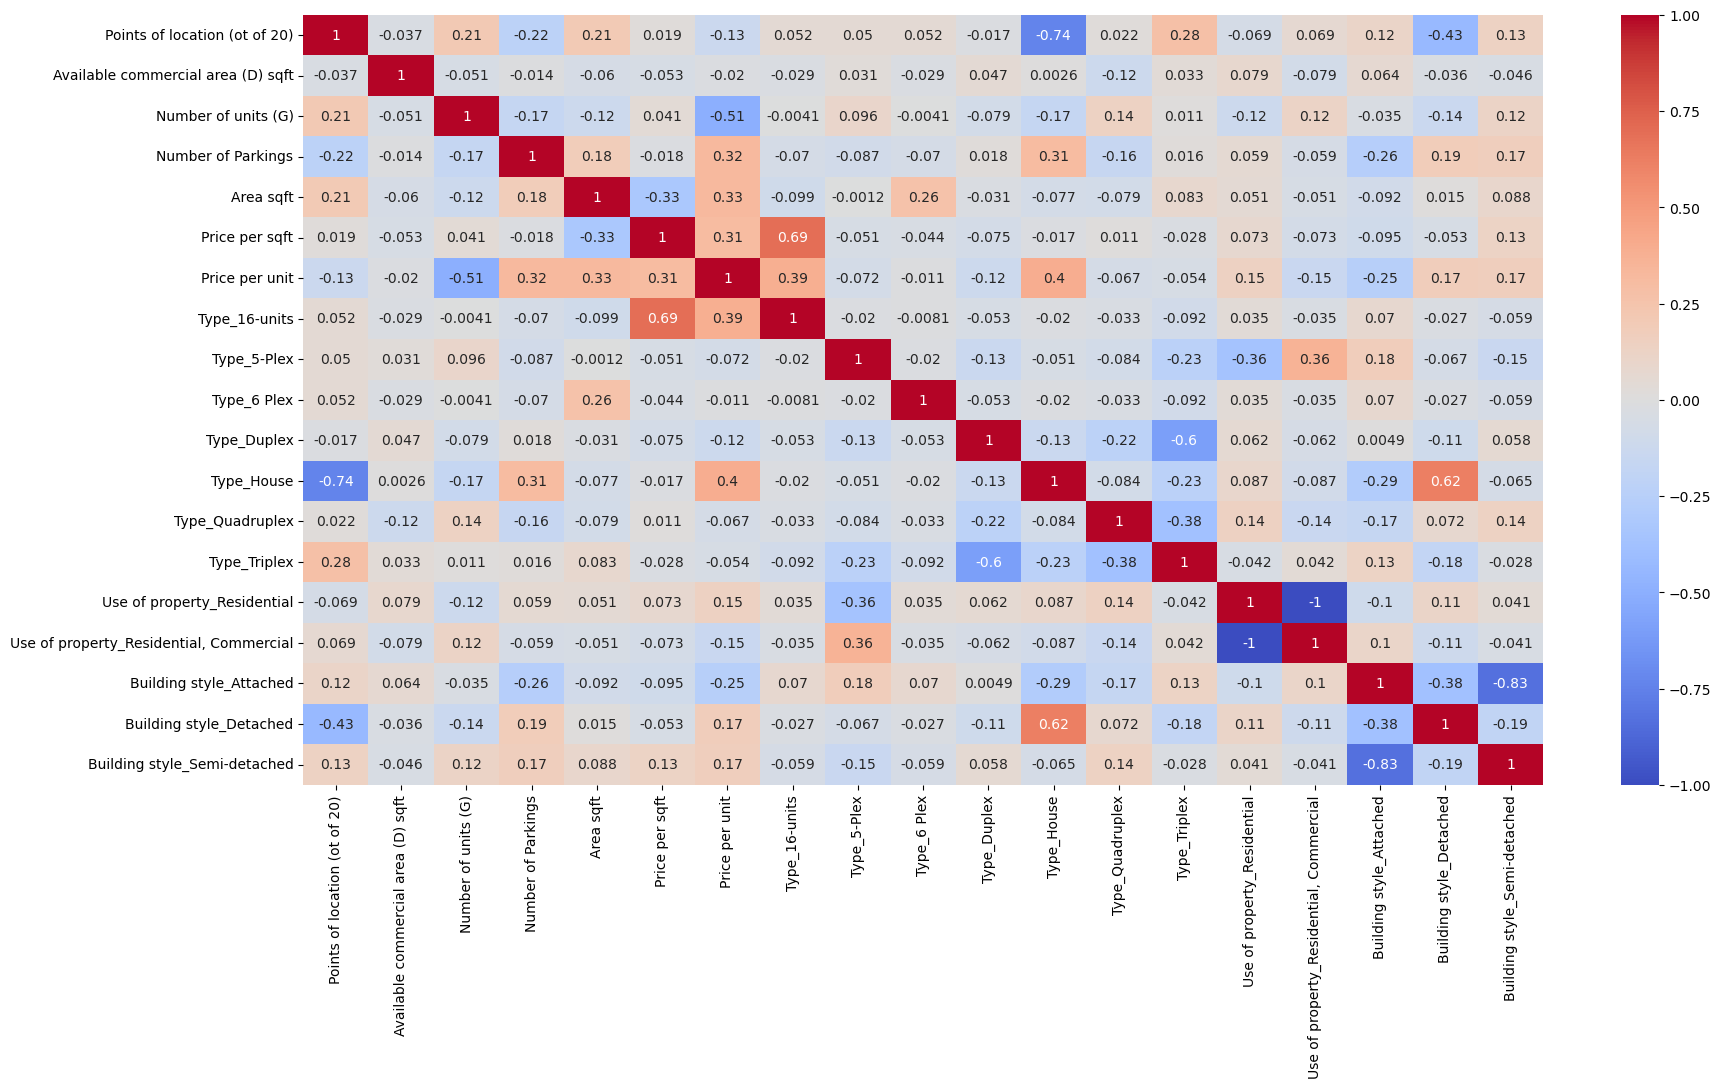

In [69]:
# Here we can see the correlation between each two features
import seaborn as sns

sns.heatmap(X.corr(), annot=True, cmap="coolwarm")

In [95]:
A = df2.sort_values([ 'Number of units (G)', 'Price per sqft'])

In [98]:
A.tail(10)

,Points of location (ot of 20),Available commercial area (D) sqft,Number of units (G),Number of Parkings,Area sqft,Price per sqft,Price per unit,Type_16-units,Type_5-Plex,Type_6 Plex,Type_Duplex,Type_House,Type_Quadruplex,Type_Triplex,Use of property_Residential,"Use of property_Residential, Commercial",Building style_Attached,Building style_Detached,Building style_Semi-detached
86,11,0.0,5.0,0.0,2027.0,443.512580,179800.000000,0,0,0,1,0,0,0,1,0,1,0,0
53,14,0.0,5.0,0.0,2771.0,450.739805,249800.000000,0,0,0,0,0,0,1,0,1,0,0,1
51,14,1100.0,5.0,0.0,2750.0,454.181818,249800.000000,0,1,0,0,0,0,0,1,0,1,0,0
0,17,0.0,5.0,0.0,1849.0,648.999459,240000.000000,0,1,0,0,0,0,0,0,1,1,0,0
50,3,0.0,5.0,6.0,1283.0,700.701481,179800.000000,0,0,0,0,1,0,0,1,0,0,1,0
13,14,0.0,6.0,0.0,2427.0,531.520396,215000.000000,0,0,0,0,0,0,1,0,1,1,0,0
20,14,0.0,6.0,1.0,3078.0,548.408057,281333.333333,0,0,0,0,0,0,1,1,0,0,0,1
141,14,0.0,6.0,0.0,1284.0,2176.791277,465833.333333,0,0,0,0,0,1,0,1,0,0,0,1
146,17,0.0,8.0,2.0,2026.0,752.714709,190625.000000,0,0,0,0,0,0,1,1,0,1,0,0
140,14,0.0,13.0,0.0,2133.0,532.114393,87307.692308,0,0,0,0,0,1,0,1,0,0,0,1
